In [267]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier

In [2]:

digits = load_digits()

print(digits.keys())

data = digits["data"] #flattened version of images
images = digits["images"] # images in array form; each image is of shape (8,8)
target = digits["target"] # indices of target_names array belonging to test data (1797)
target_names = digits["target_names"] # numbers 0 to 9



dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


(8, 8)


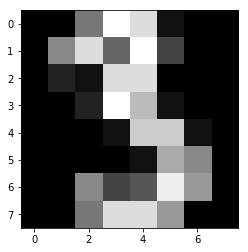

In [3]:
%matplotlib inline
img = images[(np.where(target == 3)[0][0])]
print(img.shape)
plt.figure()
plt.gray()
plt.imshow(img,interpolation="nearest");
#print(np.size(np.where(target == 4)[0][0]))
#print(np.where(target == 4))

In [4]:
def dist_loop(training,test):
    """ Naive distance function; loops over each pixel and calculates nearest neighbor
        training: (N,D) matrix. N number of training data, D number of pixels
        test: (M,D) matrix. M number of test data, D number of pixels
        
        returns (N,M) distance matrix
    """
    N,D = training.shape
    M = test.shape[0]
    dist_matrix = np.empty(shape=(N,M))
    for i in np.arange(0,N):
        for j in np.arange(0,M):
            eucl_sum = 0
            for k in np.arange(0,D):
                eucl_sum += np.square(training[i,k]-test[j,k]) # veeeery slow, alternatively use np.sum and skip loop over D
            dist_matrix[i,j] = np.sqrt(eucl_sum)
    return dist_matrix


def dist_loop2(training,test):
    """Naive distance function; loops over each pixel and calculates nearest neighbor
        training: (N,D) matrix. N number of training data, D number of pixels
        test: (M,D) matrix. M number of test data
        
        returns (N,M) distance matrix
    """
    #Ns, Ms = np.meshgrid(training,test)
    N = training.shape[0]
    M = test.shape[0]
    dist_matrix = np.empty(shape=(N,M))
    for i in np.arange(0,N):
        for j in np.arange(0,M):
            dist_matrix[i,j] = np.sqrt(np.sum(np.square(training[i,:]-test[j,:]))) # still slow
    return dist_matrix

def dist_vec(training,test):
    """Fast, vectorized implementation of nearest neighbor classifier
        training: (N,D) numpy array. N number of training data, D number of pixels
        test: (M,D) numpy array. M number of test data, D number of pixels
        
        FAAAAAST!!!
        
        returns (N,M) distance matrix
    """
    Ns, Ms = np.meshgrid(np.arange(0,training.shape[0]),np.arange(0,test.shape[0]))
    dist_matrix = np.sqrt(np.sum(np.square(training[Ns,:]-test[Ms,:]),axis=2))
    return np.transpose(dist_matrix)


def k_Nearest_Neighbor_Classifier(X_train,Y_train, X_test,k):
    """k Nearest neighbour classifier
        
        VARIABLES
        X_train: features of training data
        Y_train: instances of training data
        X_test: features of test data
        
        PARAMETER
        k: number of neighbors to be taken into account
        
        
        RELIES ON dist_vec function!!
        ----------------
    """
    distance_matrix = dist_vec(X_train,X_test)
    indices = np.argpartition(distance_matrix,kth=k,axis=0)[:k,:] #find k nearest neighbours (column mimima) of distance matrix
    k_neighbors = Y_train[indices] #assign corresponding training instances to each test point
    test_instance_histo = [np.bincount(k_neighbors[:,i],minlength=10) for i in np.arange(0,len(k_neighbors[0,:]))]
    test_instance = np.argmax(test_instance_histo,axis=1)
    #print(test_instance.shape)
    #print(np.argmax(test_instance,axis=1))
    return test_instance

In [5]:
X_all = data
Y_all = target

X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(digits.data,digits.target,test_size=0.4,random_state=0)

#%timeit dist_loop(X_train,X_test)
%timeit dist_loop2(X_train,X_test)
%timeit dist_vec(X_train,X_test)

4.94 s ± 66.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
380 ms ± 66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
print("Deviations of the distance matrices returned from both implementations:", np.sum(dist_loop2(X_train,X_test)!=dist_vec(X_train,X_test)))

Deviations of the distance matrices returned from both implementations: 0


In [6]:
def filter_numbers(number1,number2):
    """Returns subset of digits sample data containing only the numbers passed to the function
        
       Takes number1 and number2 of the target_names as its arguments
       Returns two arrays: data, target
    """
    #if number1 and number2:
    if True:
        indices = np.where((digits['target'] == number1) | (digits['target'] == number2))
        #print(indices)
        data = (digits['data'])[indices]
        target = (digits['target'])[indices]
        #print(indices)
    return data, target

In [7]:
## Numbers 1 and 3
print("Subset numbers 1 and 3")
data_1_3, target_1_3 = filter_numbers(1,3)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(data_1_3,target_1_3,test_size=0.4)
Y_test_estimate = k_Nearest_Neighbor_Classifier(X_train,Y_train,X_test,1)

print("Error of K nearest neighbor classifier: %.5f" % (1 - np.sum(Y_test==Y_test_estimate)/len(Y_test)))


## Numbers 3 and 9
print("Subset numbers 3 and 9")
data_3_9, target_3_9 = filter_numbers(3,9)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(data_3_9,target_3_9,test_size=0.4)
Y_test_estimate = k_Nearest_Neighbor_Classifier(X_train,Y_train,X_test,1)

print("Error of K nearest neighbor classifier: %.5f" % (1 - np.sum(Y_test==Y_test_estimate)/len(Y_test)))


## what is standard deviation?

Subset numbers 1 and 3
Error of K nearest neighbor classifier: 0.00000
Subset numbers 3 and 9
Error of K nearest neighbor classifier: 0.01370


In the following we investigate the dependency of the error of recoginizing 3's and 9's for k nearest neighbors with k in {1,3,5,9,17,33}. We average over N times to account for "good" and "bad" sampling of training sets.

<Container object of 3 artists>

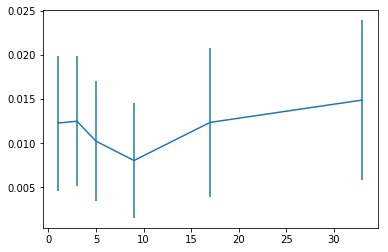

In [23]:
k = [1,3,5,9,17,33]
data_3_9, target_3_9 = filter_numbers(3,9)
N = 100
error_k = np.empty((len(k),N))

for j in np.arange(0,N): 
    X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(data_3_9,target_3_9,test_size=0.4)
    for index, i in enumerate(k):
        Y_test_estimate = k_Nearest_Neighbor_Classifier(X_train,Y_train,X_test,i)
        error_k[index,j] = (1 - np.sum(Y_test==Y_test_estimate)/len(Y_test))
plt.errorbar(k,np.mean(error_k,axis=1),yerr=np.std(error_k,axis=1))


In [279]:
### split array in chunks of equal size

def chunks(l, n):
    """Yield succesive n chunks from l. 
    
    Generator function
    """
    for i in np.linspace(0, (len(l)-int(round(len(l)/n))), n,dtype=int):
        yield l[i:(i + int(round(len(l)/n)))]
        
def cross_validation(feature,instance,n):
    """Yield succesive n training and test sets by permutating and reassembling of the n chunks of features and instances
    
        Generator function
    """
    chunked_data, chunked_target = np.asarray([a for a in chunks(feature,n)]), np.asarray([a for a in chunks(instance,n)]) # list of arrays
    
    for i in np.arange(0,n):
        x_complement =  np.delete(chunked_data, i,axis=0)
        #print(x_complement[0].shape)
        #x_test = x_complement.reshape(-1,x_complement.shape[-1])
        x_test = np.concatenate([j for j in x_complement])
        #print(x_test.shape)
        y_complement =  np.delete(chunked_target, i, axis=0)
        #y_test = y_complement.reshape(y_complement.shape[0]*y_complement.shape[1],)
        #print(y_complement.shape)
        y_test = y_complement.flatten()
        x_training = chunked_data[i]
        y_training = chunked_target[i]
        yield x_training, y_training, x_test, y_test
    
    

In [286]:
data, target = digits['data'], digits['target']
N = [2,5,10]
k= 5
for n in N:
    error_1 = np.empty(n) ##own implementation
    error_2 = np.empty(n) ## scikit learn
    
    for index, (x_training,y_training,x_test,y_test) in enumerate(cross_validation(data[1:],target[1:],n)):
    # enumerate cross_validation operator and save error of prediction to the 2 arrays
        scikit = KNeighborsClassifier(n_neighbors=k)
        y_estimates = k_Nearest_Neighbor_Classifier(x_training,y_training,x_test,k)
        error_1[index] = 1 - np.sum(y_test==y_estimates)/len(y_test)

        scikit.fit(x_training,y_training)
        y_estimates_scikit = scikit.predict(x_test)
        error_2[index] = 1 - np.sum(y_test==y_estimates_scikit)/len(y_test)
    print("n = %d subparts:" % n)
    print("average error own implementation: %.3f +- %.3f" % (np.mean(error_1),np.std(error_1)))
    print("average error scikit implementation: %.3f +- %.3f" % (np.mean(error_2),np.std(error_2)))

n = 2 subparts:
average error own implementation: 0.048 +- 0.003
average error scikit implementation: 0.048 +- 0.003
n = 5 subparts:
average error own implementation: 0.092 +- 0.006
average error scikit implementation: 0.092 +- 0.006
n = 10 subparts:
average error own implementation: 0.145 +- 0.026
average error scikit implementation: 0.145 +- 0.026


In [273]:
error_1

array([ 0.0954039 ,  0.08356546,  0.09679666,  0.09888579,  0.0856546 ])

In [98]:
a = a.reshape(-1,a.shape[1])
a

array([[1, 2],
       [3, 4]])

In [108]:
o = chunked_data.reshape(-1,chunked_data.shape[-1])

In [109]:
o.shape

(365, 64)